<a href="https://colab.research.google.com/github/dchug2/ATMS597_Project6_GroupA/blob/master/MLE_SACZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Can soil moisture improve precipitation forecasts at intraseasonal timescale?
#### Chase, R. J., Chug, D., Miller, R. M.

This notebook uses multiple linear regression technique to setup a baseline prediction for intraseasonal precipitation over Central East Brazil, a region also known as the terrestrial part of the South Atlantic Convergence Zone (SACZ). There is evidence in literature that shows ENSO and MJO are two potential predictors. We want to test the suitability of soil moisture in the region as another predictor of intraseasonal precipitation.

In [0]:
#mount google drive to current runtime
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Academics/ATMS597_dataanalysis/Project6/ATMS597_Project6_RoRaDi

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Academics/ATMS597_dataanalysis/Project6/ATMS597_Project6_RoRaDi


In [0]:
!pip install netcdf4
import numpy as np
import pandas as pd
import netCDF4
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

     |████████████████████████████████| 4.1MB 2.8MB/s 
     |████████████████████████████████| 327kB 31.5MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Let's read in our data 
#### 1. MJO amp, phase and dates

In [0]:
# MJO amplitude and phase
xr_mjo_amp = xr.open_dataset('Data/RMM_MJO_amplitude.nc')
xr_mjo_phi = xr.open_dataset('Data/RMM_MJO_phase.nc')
MJO_amp = xr_mjo_amp.amplitude.values
MJO_phase = xr_mjo_phi.phase.values

# MJO RMM PCs
# MJO amplitude and phase
xr_mjo_pc1 = xr.open_dataset('Data/RMM_MJO_PC1.nc')
xr_mjo_pc2 = xr.open_dataset('Data/RMM_MJO_PC2.nc')
MJO_pc1 = xr_mjo_pc1.RMM1.values
MJO_pc2 = xr_mjo_pc2.RMM2.values

In [0]:
xr_mjo_pc1

<xarray.Dataset>
Dimensions:  (T: 16768)
Coordinates:
  * T        (T) float32 2442200.0 2442201.0 2442202.0 ... 2458966.0 2458967.0
Data variables:
    RMM1     (T) float32 1.63447 1.60289 1.51625 ... 0.5583222 0.9825709

In [0]:
pip install julian

In [0]:
import julian
MJO_date1 = [julian.from_jd(date, fmt='jd') for date in xr_mjo_amp.T.values]
MJO_df1 = pd.DataFrame({'mjo_amp': MJO_amp, 'mjo_phase': MJO_phase}, index = MJO_date1)

MJO_date2 = [julian.from_jd(date, fmt='jd') for date in xr_mjo_pc1.T.values]
MJO_df2 = pd.DataFrame({'mjo_pc1': MJO_pc1, 'mjo_pc2': MJO_pc2}, index = MJO_date2)

MJO_df = MJO_df2.join(MJO_df1)
MJO_df.index = MJO_df.index.date
#MJO_df['date'] = MJO_df.index
MJO_df

,mjo_pc1,mjo_pc2,mjo_amp,mjo_phase
1974-06-01,1.634470,1.203040,2.029480,5.0
1974-06-02,1.602890,1.015120,1.897290,5.0
1974-06-03,1.516250,1.085510,1.864760,5.0
1974-06-04,1.509810,1.035730,1.830920,5.0
1974-06-05,1.559060,1.305180,2.033260,5.0
...,...,...,...,...
2020-04-23,-0.395876,-2.008943,2.047577,2.0
2020-04-24,-0.242871,-2.137326,2.151081,2.0
2020-04-25,0.245756,-2.100752,2.115078,3.0
2020-04-26,0.558322,-1.859305,1.941324,3.0


#### 2. ENSO index and dates (Oceanic Nino Index)

In [0]:
# ENSO index (or ONI)
#def read_pdcol(K):
#  enso_mon = pd.read_csv('Data/ONI_CPC.csv', usecols = [0, K], names = ['year', 'oni'])
#  index = pd.to_datetime(enso_mon.year.astype(str) + str(K).zfill(2),  format='%Y%m')
#  enso_mon = enso_mon.set_index(index).drop(['year'], axis = 1)
#  return enso_mon

#enso = pd.concat([read_pdcol(K) for K in range(1,13)]).sort_index().resample('d').ffill()
#enso.index.name = None
#enso

In [0]:
# Nino 3.4 index from SST OI v2
xr_enso = xr.open_dataset('Data/inino34_daily.nc')
enso = pd.DataFrame({'nino34': xr_enso.Nino34.values}, index = pd.DatetimeIndex(xr_enso.time.values))
enso

,nino34
1981-01-01,NaN
1981-01-02,NaN
1981-01-03,NaN
1981-01-04,NaN
1981-01-05,NaN
...,...
2020-12-27,NaN
2020-12-28,NaN
2020-12-29,NaN
2020-12-30,NaN


#### 3. IMERG ppt and GLEAM SM data , and create dates

In [0]:
dates = pd.date_range(start = "2003-01-01", end = "2018-12-31")
pre = np.loadtxt('Data/IMERG_dailyppt_SACZ_2003-2018.csv')
SM_root = np.loadtxt('Data/Gleam_SMroot_SACZ_2003-2018.csv')
SM_sfc = np.loadtxt('Data/Gleam_SMsurf_SACZ_2003-2018.csv') 
hydro = pd.DataFrame({'pre': pre, 'SM_root': SM_root, 'SM_sfc': SM_sfc}, index = dates)

# Calculate monthly anomalies for pre, SM_root and SM_sfc
hydro_anom = (hydro.groupby(lambda x: x.month).transform(lambda x: (x - x.mean())))

hydro_anom

,pre,SM_root,SM_sfc
2003-01-01,5.701057,0.025838,0.046563
2003-01-02,3.067581,0.027040,0.050222
2003-01-03,3.381673,0.028771,0.053112
2003-01-04,-0.415904,0.028614,0.039978
2003-01-05,4.709127,0.028831,0.039823
...,...,...,...
2018-12-27,3.031827,NaN,NaN
2018-12-28,4.340134,NaN,NaN
2018-12-29,2.708353,NaN,NaN
2018-12-30,1.598231,NaN,NaN


Merge datasets together

In [0]:
# join enso, MJO and hydro
df_data = MJO_df.join([enso, hydro_anom]).copy(deep = True)
# retain precip data separately, so we can lag it by 30 days
hydro_anom.rename(columns = {'pre':'pre_lag'}, inplace = True)
hydro_anom = hydro_anom.shift(-30)
# add the retained precipitation of future time
df_data = df_data.join([hydro_anom['pre_lag']])
df_data

,mjo_pc1,mjo_pc2,mjo_amp,mjo_phase,nino34,pre,SM_root,SM_sfc,pre_lag
1974-06-01,1.634470,1.203040,2.029480,5.0,NaN,NaN,NaN,NaN,NaN
1974-06-02,1.602890,1.015120,1.897290,5.0,NaN,NaN,NaN,NaN,NaN
1974-06-03,1.516250,1.085510,1.864760,5.0,NaN,NaN,NaN,NaN,NaN
1974-06-04,1.509810,1.035730,1.830920,5.0,NaN,NaN,NaN,NaN,NaN
1974-06-05,1.559060,1.305180,2.033260,5.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2020-04-23,-0.395876,-2.008943,2.047577,2.0,NaN,NaN,NaN,NaN,NaN
2020-04-24,-0.242871,-2.137326,2.151081,2.0,NaN,NaN,NaN,NaN,NaN
2020-04-25,0.245756,-2.100752,2.115078,3.0,NaN,NaN,NaN,NaN,NaN
2020-04-26,0.558322,-1.859305,1.941324,3.0,NaN,NaN,NaN,NaN,NaN


In [0]:
# subset data to 2003-2018, drop NaNs and save the dataframe
start = datetime.date(2003, 1, 1)
end = datetime.date(2019, 1, 1)
datemask = (df_data.index >= start) & (df_data.index < end)
save_df = df_data.loc[datemask].copy(deep = True)
save_df.dropna(inplace = True)
save_df.to_pickle('Data/roradi_df.pkl')
save_df

,mjo_pc1,mjo_pc2,mjo_amp,mjo_phase,nino34,pre,SM_root,SM_sfc,pre_lag
2003-01-01,1.283340,0.013776,1.283410,5.0,1.267218,5.701057,0.025838,0.046563,-3.722759
2003-01-02,0.970201,0.151716,0.981992,5.0,1.257177,3.067581,0.027040,0.050222,-2.867133
2003-01-03,0.743909,0.391745,0.840752,5.0,1.211206,3.381673,0.028771,0.053112,-0.782897
2003-01-04,0.670488,0.438670,0.801241,5.0,1.122926,-0.415904,0.028614,0.039978,-2.099054
2003-01-05,0.485641,0.173382,0.515663,5.0,1.144655,4.709127,0.028831,0.039823,-4.381523
...,...,...,...,...,...,...,...,...,...
2018-09-26,-1.016638,0.540856,1.151554,8.0,0.817059,-0.433414,0.002275,-0.002830,-1.009200
2018-09-27,-1.070097,0.479518,1.172623,8.0,0.784065,-0.460762,0.001910,-0.003640,1.090793
2018-09-28,-1.183122,0.255574,1.210411,8.0,0.796215,-0.470408,0.001495,-0.004444,13.051461
2018-09-29,-1.392133,0.211468,1.408102,8.0,0.806719,-0.447370,0.001430,-0.001661,3.584484


Rolling window mean on pre, SM_root and SM_surf, to focus on the slow signal

In [0]:
###################
# Add a convolve functions to do a 30-day running mean on the data here
df_data['SM_root'] = df_data['SM_root'].rolling(30, center = True).mean()
df_data['SM_sfc'] = df_data['SM_sfc'].rolling(30, center = True).mean()
df_data['pre'] = df_data['pre'].rolling(30, center = True).mean()
df_data['pre_lag'] = df_data['pre_lag'].rolling(30, center = True).mean()
#df_data['mjo_pc1_smooth'] = df_data['mjo_pc1'].rolling(30, center = True, min_periods = 30).mean()
#df_data['mjo_pc2_smooth'] = df_data['mjo_pc2'].rolling(30, center = True, min_periods = 30).mean()
df_data['mjo_amp_smooth'] = df_data['mjo_amp'].rolling(30, center = True).mean()
df_data['nino34_smooth'] = df_data['nino34'].rolling(30, center = True).mean()
###################
# Save the dataframe
start = datetime.date(2003, 1, 1)
end = datetime.date(2019, 1, 1)
datemask = (df_data.index >= start) & (df_data.index < end)
save_df = df_data.loc[datemask].copy(deep = True)
save_df.dropna(inplace = True)
#save_df.set_index(pd.DatetimeIndex(save_df.index))
save_df.to_pickle('Data/roradi_df_smooth_nino34_mjo.pkl')
#save_df.to_pickle('Data/roradi_df_smooth.pkl')
save_df

,mjo_pc1,mjo_pc2,mjo_amp,mjo_phase,nino34,pre,SM_root,SM_sfc,pre_lag,mjo_amp_smooth,nino34_smooth
2003-01-16,-0.777080,0.788010,1.106710,7.0,0.930344,1.647427,0.026193,0.031361,-1.865850,0.815463,0.866591
2003-01-17,-0.925970,0.590461,1.098210,8.0,0.887793,1.333300,0.026171,0.030602,-1.765965,0.797835,0.840954
2003-01-18,-0.846530,0.445489,0.956596,8.0,0.827557,1.135476,0.025972,0.029496,-1.654435,0.792994,0.814361
2003-01-19,-0.865040,0.492584,0.995454,8.0,0.813253,0.996657,0.025656,0.028262,-1.644317,0.792928,0.786310
2003-01-20,-0.339460,0.316589,0.464182,8.0,0.806353,0.940552,0.025265,0.027231,-1.704613,0.792772,0.759723
...,...,...,...,...,...,...,...,...,...,...,...
2018-09-12,-0.560436,-0.279639,0.626328,1.0,-0.051807,-0.108417,0.003233,0.000079,0.009463,0.778277,0.384997
2018-09-13,-0.294364,-0.545742,0.620068,2.0,0.001222,-0.119755,0.003270,0.000091,0.061181,0.799788,0.406091
2018-09-14,0.106561,-0.647082,0.655798,3.0,0.068845,-0.130735,0.003286,-0.000152,0.511910,0.827327,0.423131
2018-09-15,0.572088,-0.749807,0.943131,3.0,0.120221,-0.142343,0.003317,-0.000186,0.646305,0.853874,0.430552


In [0]:
# check that 'pre_lag' at index = 0 (i.e. -1.8658) should be same as 'pre' at index = 30
save_df.iloc[30]

mjo_pc1           1.080782
mjo_pc2           0.735133
mjo_amp           1.307100
mjo_phase         5.000000
nino34            0.895992
pre              -1.010825
SM_root          -0.012912
SM_sfc           -0.023030
pre_lag           0.153159
mjo_amp_smooth    1.063106
nino34_smooth     0.716958
Name: 2003-03-02, dtype: float64

In [0]:
del save_df
del df_data

## Toward multiple linear regression

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8bd975710>,
      dtype=object)

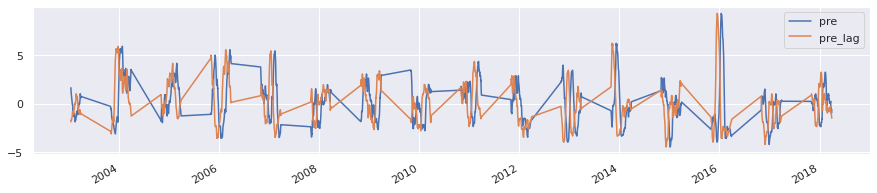

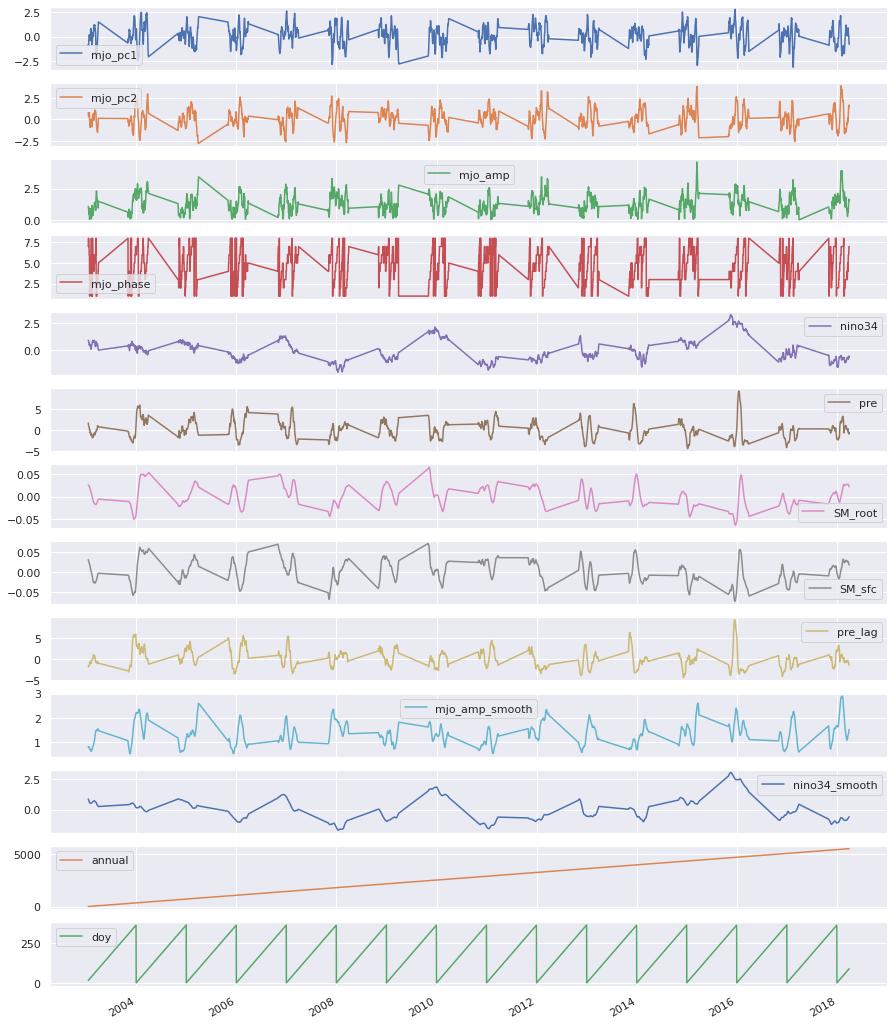

In [0]:
# load data
MLE_df = pd.read_pickle('Data/roradi_df_smooth_nino34_mjo.pkl')
MLE_df.index = pd.to_datetime(MLE_df.index)

# add number of days passed, to capture linear trends
MLE_df['annual'] = (MLE_df.index - MLE_df.index[0]).days

# add DOY to capture any annual cycle dependencies
MLE_df['doy'] = MLE_df.index.dayofyear

# Let's focus on the NDJFM season
datemask = ((MLE_df.index.month >= 11) | (MLE_df.index.month <= 3))
MLE_df = MLE_df.loc[datemask].copy(deep = True)

# plot precipitation data
MLE_df[['pre', 'pre_lag']].plot(figsize = (15, 3))

# pairwise comparison
#column_names2 = ['pre_lag','pre', 'SM_root', 'SM_sfc', 'oni', 'mjo_amp']
#g = sns.pairplot(MLE_df[column_names2])

# plot all forcings
MLE_df.plot(subplots=True, figsize=(15, 20))

In [0]:
MLE_df.corr()

,mjo_pc1,mjo_pc2,mjo_amp,mjo_phase,nino34,pre,SM_root,SM_sfc,pre_lag,mjo_amp_smooth,nino34_smooth,annual,doy
mjo_pc1,1.000000,-0.108491,-0.047215,-0.103564,0.048303,-0.105566,0.029210,-0.039685,0.012513,-0.064631,0.073438,-0.027340,0.116291
mjo_pc2,-0.108491,1.000000,0.233811,0.711409,-0.142242,-0.054374,-0.149048,-0.134239,0.025754,0.162302,-0.127004,0.036912,-0.203506
mjo_amp,-0.047215,0.233811,1.000000,0.118950,-0.006187,-0.027604,-0.067416,-0.069418,0.062251,0.794636,0.000123,0.084950,-0.212313
mjo_phase,-0.103564,0.711409,0.118950,1.000000,-0.081019,-0.019605,-0.093728,-0.079673,0.014552,0.067284,-0.068375,-0.006580,-0.168346
nino34,0.048303,-0.142242,-0.006187,-0.081019,1.000000,-0.009554,-0.129072,-0.132292,-0.045928,-0.001492,0.986460,0.024936,0.117330
pre,-0.105566,-0.054374,-0.027604,-0.019605,-0.009554,1.000000,0.524759,0.771816,-0.108800,-0.041664,-0.016319,-0.175015,0.027555
SM_root,0.029210,-0.149048,-0.067416,-0.093728,-0.129072,0.524759,1.000000,0.926049,-0.283661,-0.114214,-0.131878,-0.193945,0.022227
SM_sfc,-0.039685,-0.134239,-0.069418,-0.079673,-0.132292,0.771816,0.926049,1.000000,-0.228529,-0.113516,-0.137995,-0.184148,0.047066
pre_lag,0.012513,0.025754,0.062251,0.014552,-0.045928,-0.108800,-0.283661,-0.228529,1.000000,0.078773,-0.046139,-0.233729,0.004840
mjo_amp_smooth,-0.064631,0.162302,0.794636,0.067284,-0.001492,-0.041664,-0.114214,-0.113516,0.078773,1.000000,-0.002797,0.126073,-0.299420


In [0]:
from scipy.stats import pearsonr
pearsonr(MLE_df['SM_root'].values, MLE_df['pre_lag'].values)

(-0.28366056557111263, 1.2635071791048636e-44)

1. Among other things, this shows that we have high correlated forcings (SMroot and SMsfc) in the model </br>
2. An important point to note here is that concurrent precipitation has a higher pearson correlation with surface SM than with root-zone SM, but future precipitation has a higher correlation with root-zone SM. This opens up possibilities for a slow SM feedback to precipitation modulated by root-zone SM. To describe this, precipitation forces surface SM directly (can be shown by hyperspectral analysis), this effect gets filtered and phase-lagged as it reaches the root-zone SM. This slower signal of the root-zone in turn causes a slow feedback into the atmosphere.

In [0]:
predictand = 'pre_lag'

# split data into training and testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y = MLE_df[predictand]
X = MLE_df.drop([predictand],axis=1)
#[X.drop([col], axis = 1, inplace = True) for col in remove_cols]
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size = 0.1,random_state = 10)
X_scaled_df

,mjo_pc1,mjo_pc2,mjo_amp,mjo_phase,nino34,pre,SM_root,SM_sfc,mjo_amp_smooth,nino34_smooth,annual,doy
0,-0.877302,0.568530,-0.354856,1.088020,0.906070,0.685918,1.025129,1.039711,-1.144898,0.861545,-1.730753,-0.999734
1,-1.023042,0.393502,-0.366805,1.562145,0.865276,0.547775,1.024231,1.013495,-1.181726,0.836377,-1.730141,-0.992739
2,-0.945282,0.265057,-0.565891,1.562145,0.807529,0.460778,1.016253,0.975305,-1.191840,0.810269,-1.729529,-0.985745
3,-0.963401,0.306783,-0.511263,1.562145,0.793815,0.399730,1.003530,0.932708,-1.191978,0.782730,-1.728918,-0.978750
4,-0.448940,0.150851,-1.258141,1.562145,0.787200,0.375057,0.987816,0.897136,-1.192305,0.756629,-1.728306,-0.971756
...,...,...,...,...,...,...,...,...,...,...,...,...
2339,0.090365,1.060318,0.000703,0.613895,-0.625175,-0.392266,0.998926,0.730579,0.050429,-0.619913,1.664840,-0.510116
2340,-0.064705,1.196275,0.194483,0.613895,-0.650446,-0.417530,0.967235,0.673964,0.100497,-0.602402,1.665452,-0.503121
2341,-0.394262,1.338288,0.452371,1.088020,-0.574915,-0.460624,0.930850,0.623241,0.164440,-0.586274,1.666064,-0.496127
2342,-0.716669,1.122453,0.254865,1.088020,-0.479926,-0.427563,0.896103,0.596583,0.245955,-0.573269,1.666676,-0.489132


#### Model #1: All predictors

RMSE for training dataset =  2.0149321013970987


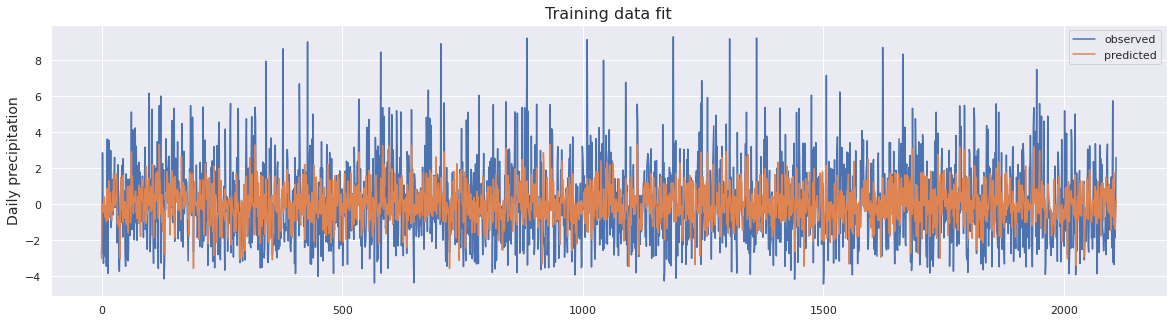

In [0]:
# setup a linear regressor and fit the training data
MLE_allfeatures = LinearRegression(fit_intercept = False)
MLE_allfeatures.fit(X_train, y_train)
predicted_train =  MLE_allfeatures.predict(X_train)

# Calculate RMSE on training data
rmse_train = np.sqrt(mean_squared_error(y_train, predicted_train))
print('RMSE for training dataset = ', rmse_train)

# plot the predicted and predictand data
fig, ax = plt.subplots(figsize = (20, 5))
xidx = np.arange(np.size(y_train))
plt.plot(xidx, y_train, label = 'observed')
plt.plot(xidx, predicted_train, label = 'predicted')
plt.title('Training data fit', fontsize = 16)
plt.ylabel('Daily precipitation', fontsize = 14)
plt.legend(loc = 'best')
plt.show()

Looks like extremes are not captured well by linear regression (duh!). </br>
Also, MJO_amp and MJO_phase are not suitable predictors for linear regression. We probably need to swap these with the PC1 and PC2 of MJO.

RMSE for test dataset =  2.0760330076024927


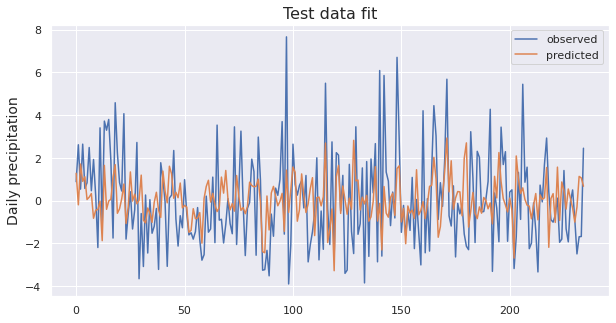

In [0]:
# Evaluate on test data
predicted_test =  MLE_allfeatures.predict(X_test)
# Calculate RMSE on test data
rmse_test = np.sqrt(mean_squared_error(y_test, predicted_test))
print('RMSE for test dataset = ', rmse_test)

# plot the predicted and predictand data
fig, ax = plt.subplots(figsize = (10, 5))
xidx = np.arange(np.size(y_test))
plt.plot(xidx, y_test, label = 'observed')
plt.plot(xidx, predicted_test, label = 'predicted')
plt.title('Test data fit', fontsize = 16)
plt.ylabel('Daily precipitation', fontsize = 14)
plt.legend(loc = 'best')
plt.show()

Not a bad fit. Are we predicting the sign right?


In [0]:
y_test_binary = np.sign(y_test)
predicted_test_binary = np.sign(predicted_test)
compare = np.equal(y_test_binary, predicted_test_binary)*1

# plot the predicted and predictand data
print('Percentage of total predicted values with correct sign =', np.sum(compare)/np.size(compare)*100, '%')

Percentage of total predicted values with correct sign = 59.148936170212764 %


That wasn't horrible. Let's see the relative weights of the predictors.

In [0]:
params = pd.Series(MLE_allfeatures.coef_, index = X_train.columns)

from sklearn.utils import resample
np.random.seed(1)
err = np.std([MLE_allfeatures.fit(*resample(X_train, y_train)).coef_
              for i in range(1000)], 0)

print(pd.DataFrame({'effect': params.round(2),
                    'error': err.round(2)}))

                effect  error
mjo_pc1           0.11   0.05
mjo_pc2          -0.08   0.07
mjo_amp           0.00   0.07
mjo_phase         0.01   0.06
nino34           -0.02   0.25
pre              -0.65   0.11
SM_root          -2.23   0.18
SM_sfc            1.89   0.25
mjo_amp_smooth    0.27   0.08
nino34_smooth    -0.13   0.24
annual           -0.74   0.04
doy               0.07   0.05


In [0]:
#baseline test score for test data
print('Baseline score for test data = ', MLE_allfeatures.score(X_test, y_test))

Baseline score for test data =  0.12759927762767787


Let's try using feature selection, to see if it selects Soil moisture or not

In [0]:
# load data
MLE_df = pd.read_pickle('Data/roradi_df_smooth_nino34_mjo.pkl')
MLE_df.index = pd.to_datetime(MLE_df.index)

# add number of days passed, to capture linear trends
MLE_df['annual'] = (MLE_df.index - MLE_df.index[0]).days

# add DOY to capture any annual cycle dependencies
MLE_df['doy'] = MLE_df.index.dayofyear

# Let's focus on the NDJFM season
datemask = ((MLE_df.index.month >= 11) | (MLE_df.index.month <= 3))
MLE_df = MLE_df.loc[datemask].copy(deep = True)

predictand = 'pre_lag'
column_names = list(MLE_df.columns)
# remove column names that are to be predicted
column_names.remove(predictand)

y = MLE_df[predictand]
X = MLE_df.drop([predictand],axis=1)
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size = 0.2,random_state = 10)
X_train_stepwise = Stepwise_MLE(X_train, y_train)

In [0]:
from sklearn.feature_selection import RFECV
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size = 0.2,random_state = 10)
MLE_selection = LinearRegression(fit_intercept = False)
selector = RFECV(MLE_selection)
selector = selector.fit(X_train, y_train)
cols = X_train.columns
selected = list(cols[selector.support_])
# test without SM_sfc
selected.remove('SM_sfc')
print(selected)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_df[selected], y, test_size = 0.2,random_state = 10)

['mjo_pc1', 'mjo_pc2', 'pre', 'SM_root', 'mjo_amp_smooth', 'nino34_smooth', 'annual', 'doy']


RMSE for training dataset =  2.043390363257214


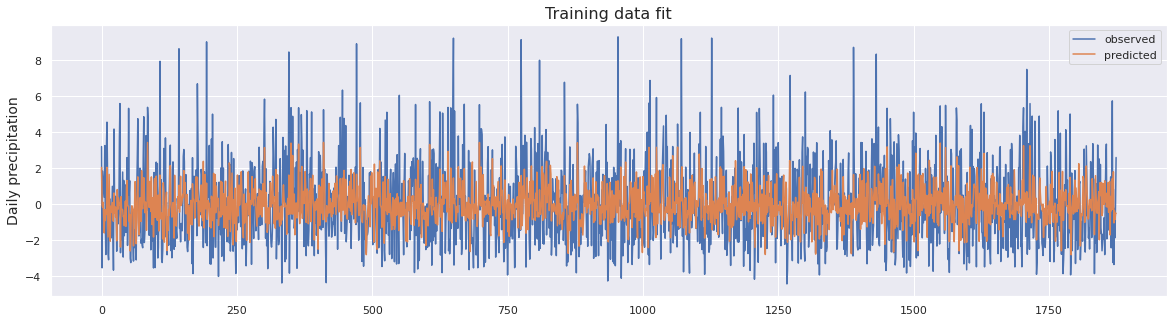

In [0]:
# setup a linear regressor and fit the training data
MLE_selection.fit(X_train, y_train)
predicted_train =  MLE_selection.predict(X_train)

# Calculate RMSE on training data
rmse_train = np.sqrt(mean_squared_error(y_train, predicted_train))
print('RMSE for training dataset = ', rmse_train)

# plot the predicted and predictand data
fig, ax = plt.subplots(figsize = (20, 5))
xidx = np.arange(np.size(y_train))
plt.plot(xidx, y_train, label = 'observed')
plt.plot(xidx, predicted_train, label = 'predicted')
plt.title('Training data fit', fontsize = 16)
plt.ylabel('Daily precipitation', fontsize = 14)
plt.legend(loc = 'best')
plt.show()

RMSE for test dataset =  2.065524960775694


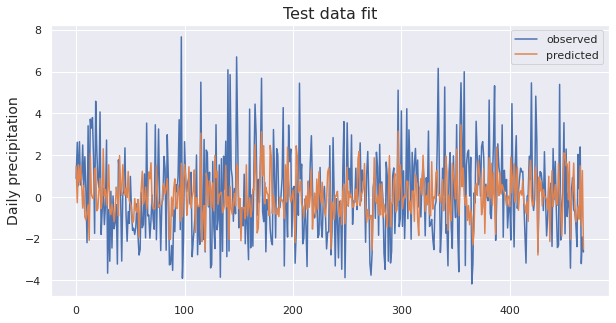

In [0]:
# Evaluate on test data
predicted_test =  MLE_selection.predict(X_test)
# Calculate RMSE on test data
rmse_test = np.sqrt(mean_squared_error(y_test, predicted_test))
print('RMSE for test dataset = ', rmse_test)

# plot the predicted and predictand data
fig, ax = plt.subplots(figsize = (10, 5))
xidx = np.arange(np.size(y_test))
plt.plot(xidx, y_test, label = 'observed')
plt.plot(xidx, predicted_test, label = 'predicted')
plt.title('Test data fit', fontsize = 16)
plt.ylabel('Daily precipitation', fontsize = 14)
plt.legend(loc = 'best')
plt.show()

In [0]:
y_test_binary = np.sign(y_test)
predicted_test_binary = np.sign(predicted_test)
compare = np.equal(y_test_binary, predicted_test_binary)*1

# plot the predicted and predictand data
print('Percentage of total predicted values with correct sign =', np.sum(compare)/np.size(compare)*100, '%')

Percentage of total predicted values with correct sign = 62.47334754797441 %


In [0]:
params = pd.Series(MLE_selection.coef_, index = X_train.columns)

from sklearn.utils import resample
np.random.seed(1)
err = np.std([MLE_selection.fit(*resample(X_train, y_train)).coef_
              for i in range(1000)], 0)

print(pd.DataFrame({'effect': params.round(2),
                    'error': err.round(2)}))

                effect  error
mjo_pc1           0.10   0.05
mjo_pc2          -0.07   0.05
pre               0.08   0.05
SM_root          -0.90   0.06
mjo_amp_smooth    0.28   0.06
nino34_smooth    -0.20   0.05
annual           -0.71   0.05
doy               0.12   0.06
